# S&P 500 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'GSPC'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-20 00:00:00-04:00,5181.689941,5226.189941,5171.549805,5224.620117,4064850000,0.0,0.0
2024-03-21 00:00:00-04:00,5253.430176,5261.100098,5240.660156,5241.529785,4207730000,0.0,0.0
2024-03-22 00:00:00-04:00,5242.479980,5246.089844,5229.870117,5234.180176,3374700000,0.0,0.0
2024-03-25 00:00:00-04:00,5219.520020,5229.089844,5216.089844,5218.189941,3331360000,0.0,0.0
2024-03-26 00:00:00-04:00,5228.850098,5235.160156,5203.419922,5203.580078,3871790000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,5594.450195,5597.779785,5504.649902,5521.520020,5018980000,0.0,0.0
2025-03-14 00:00:00-04:00,5563.850098,5645.270020,5563.850098,5638.939941,4863180000,0.0,0.0
2025-03-17 00:00:00-04:00,5635.600098,5703.520020,5631.120117,5675.120117,5031770000,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21 00:00:00-04:00,4462.399902,4481.750000,4424.299805,4461.180176,4869820000,0.0,0.0
2022-03-22 00:00:00-04:00,4469.100098,4522.000000,4469.100098,4511.609863,4754840000,0.0,0.0
2022-03-23 00:00:00-04:00,4493.100098,4501.069824,4455.810059,4456.240234,4550670000,0.0,0.0
2022-03-24 00:00:00-04:00,4469.979980,4520.580078,4465.169922,4520.160156,4131390000,0.0,0.0
2022-03-25 00:00:00-04:00,4522.910156,4546.029785,4501.069824,4543.060059,4305020000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,5594.450195,5597.779785,5504.649902,5521.520020,5018980000,0.0,0.0
2025-03-14 00:00:00-04:00,5563.850098,5645.270020,5563.850098,5638.939941,4863180000,0.0,0.0
2025-03-17 00:00:00-04:00,5635.600098,5703.520020,5631.120117,5675.120117,5031770000,0.0,0.0


## Moving Median

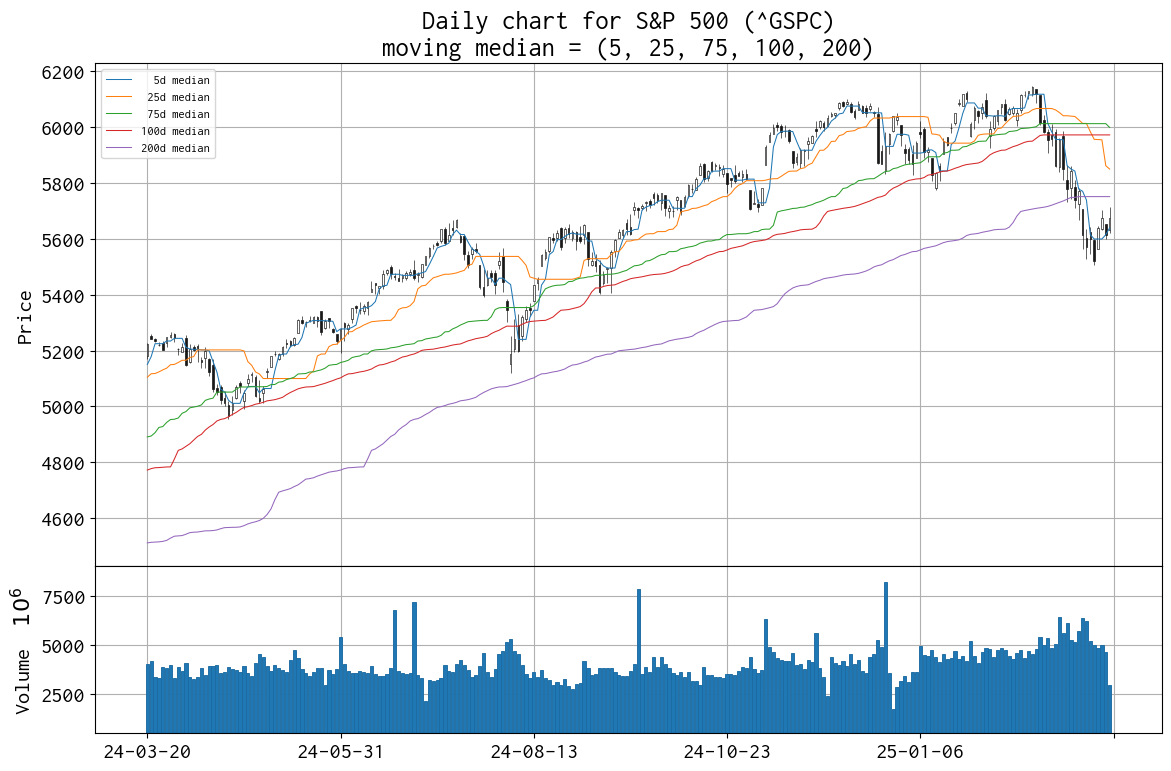

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-18 00:00:00-04:00,5654.529785,5654.529785,5597.759766,5614.660156,4666270000,0.0,0.0
2025-03-19 00:00:00-04:00,5632.370117,5715.330078,5622.200195,5675.290039,3006397000,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-18 00:00:00-04:00    5614.660156
2025-03-19 00:00:00-04:00    5675.290039
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-18 00:00:00-04:00          NaN
2025-03-19 00:00:00-04:00    60.629883
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-19 00:00:00-04:00    42.919922
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-13 00:00:00-04:00    5738.520020
2025-03-14 00:00:00-04:00    5638.939941
2025-03-17 00:00:00-04:00    5638.939941
2025-03-18 00:00:00-04:00    5614.660156
2025-03-19 00:00:00-04:00    5614.660156
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-13 00:00:00-04:00    5778.149902
2025-03-14 00:00:00-04:00    5770.200195
2025-03-17 00:00:00-04:00    5738.520020
2025-03-18 00:00:00-04:00    5675.120117
2025-03-19 00:00:00-04:00    5675.120117
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-13 00:00:00-04:00    5969.655029
2025-03-14 00:00:00-04:00    5955.655029
2025-03-17 00:00:00-04:00    5954.875000
2025-03-18 00:00:00-04:00    5908.034912
2025-03-19 00:00:00-04:00    5855.645020
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-13 00:00:00-04:00    5979.314941
2025-03-14 00:00:00-04:00    5973.109863
2025-03-17 00:00:00-04:00    5965.719971
2025-03-18 00:00:00-04:00    5965.719971
2025-03-19 00:00:00-04:00    5965.719971
Name: Close, dtype: float64

## Robust Bollinger's bands

In [13]:
period = 20
calc_robust_bollinger(df0, period)
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Median,Q1,Q3,Lower,Upper
Date,,,,,,,,,,,,
2022-03-21 00:00:00-04:00,4462.399902,4481.750000,4424.299805,4461.180176,4869820000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-22 00:00:00-04:00,4469.100098,4522.000000,4469.100098,4511.609863,4754840000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-23 00:00:00-04:00,4493.100098,4501.069824,4455.810059,4456.240234,4550670000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-24 00:00:00-04:00,4469.979980,4520.580078,4465.169922,4520.160156,4131390000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-25 00:00:00-04:00,4522.910156,4546.029785,4501.069824,4543.060059,4305020000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,5594.450195,5597.779785,5504.649902,5521.520020,5018980000,0.0,0.0,5954.875000,5776.162476,6067.635132,5338.953491,6504.844116
2025-03-14 00:00:00-04:00,5563.850098,5645.270020,5563.850098,5638.939941,4863180000,0.0,0.0,5908.034912,5762.280151,6038.504883,5347.943054,6452.841980
2025-03-17 00:00:00-04:00,5635.600098,5703.520020,5631.120117,5675.120117,5031770000,0.0,0.0,5855.645020,5713.625000,5990.719971,5297.982544,6406.362427


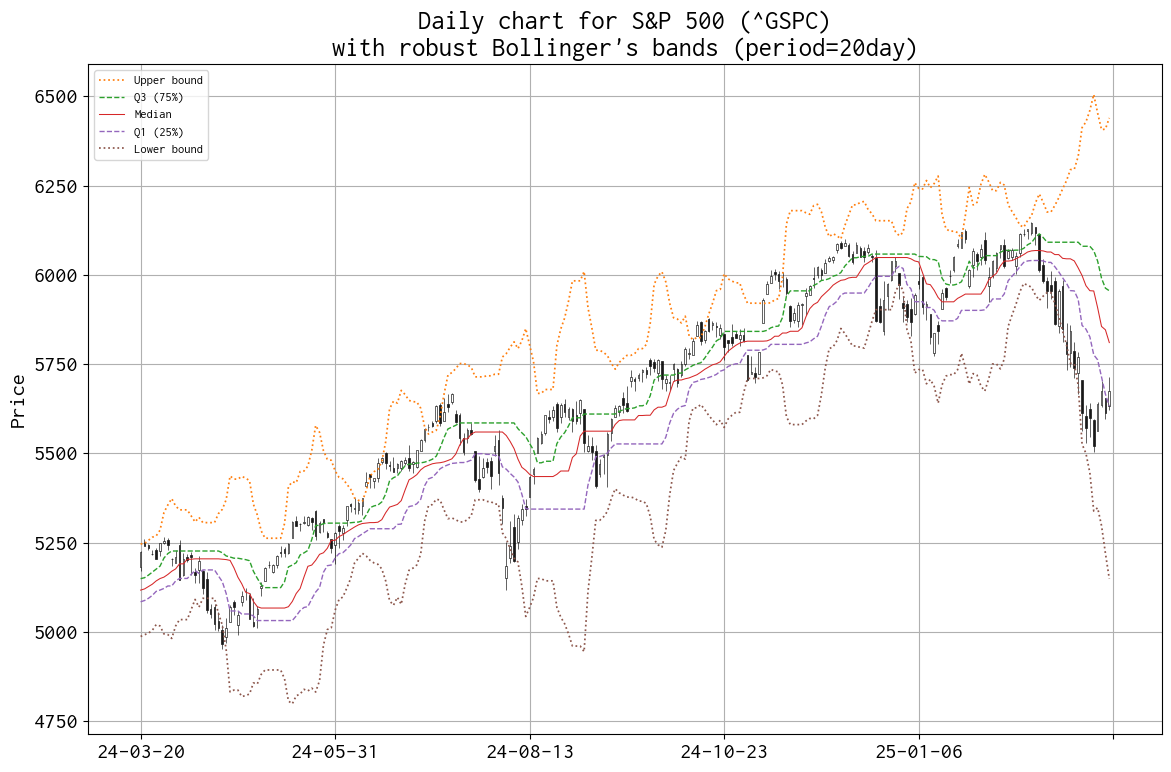

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
mv_median = df0['Median']
mv_q1 = df0['Q1']
mv_q3 = df0['Q3']
mv_lower = df0['Lower']
mv_upper = df0['Upper']

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger\'s bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger\'s bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

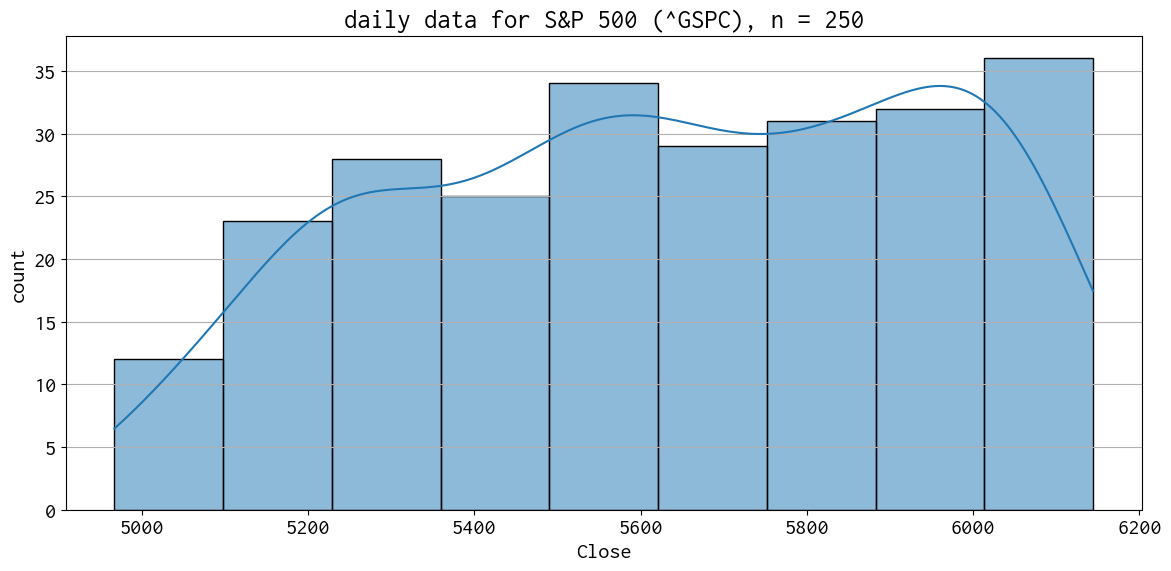

In [15]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()